### 4.4.1 训练误差和泛化误差
训练误差（training error）是指， 模型在训练数据集上计算得到的误差。 泛化误差（generalization error）是指， 模型应用在同样从原始样本的分布中抽取的无限多的数据样本时，模型误差的期望。

#### 4.4.1.2 模型复杂性
##### 当我们有简单的模型和大量的数据时，我们期望泛化误差与训练误差相近。

当我们有更复杂的模型和更少的样本时，我们预计训练误差会下降，但泛化误差会增大。
模型复杂性由什么构成是一个复杂的问题。 一个模型是否能很好地泛化取决于很多因素。
例如，具有更多参数的模型可能被认为更复杂， 参数有更大取值范围的模型可能更为复杂。
通常对于神经网络，我们认为需要更多训练迭代的模型比较复杂，
而需要“早停”（early stopping）的模型（即较少训练迭代周期）就不那么复杂。

在本节中，为了给你一些直观的印象，我们将重点介绍几个倾向于影响模型泛化的因素：

+ 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。

+ **参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合**。

+ 训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

### 4.4.2 模型选择
在机器学习中，我们通常在评估几个候选模型后选择最终的模型。 这个过程叫做模型选择。
有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。
又有时，我们需要比较不同的超参数设置下的同一类模型。

例如，训练多层感知机模型时，我们可能希望比较具有 不同数量的隐藏层、不同数量的隐藏单元以及不同的的激活函数组合的模型。
为了确定候选模型中的最佳模型，我们通常会使用**验证集。**


#### 4.4.2.1 验证集
原则上，在我们确定所有的超参数之前，我们不希望用到测试集。
如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险，那就麻烦大了。
如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。
但是如果我们过拟合了测试数据，我们又该怎么知道呢？

因此，我们决不能依靠测试数据进行模型选择。
然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。

在实际应用中，情况变得更加复杂。
虽然理想情况下我们只会使用测试数据一次， 以评估最好的模型或比较一些模型效果，但现实是测试数据很少在使用一次后被丢弃。
我们很少能有充足的数据来对每一轮实验采用全新测试集。

解决此问题的常见做法是将我们的数据分成三份， 除了训练和测试数据集之外，还增加一个验证数据集（validation dataset）， 也叫验证集（validation set）。
但现实是验证数据和测试数据之间的边界模糊得令人担忧。
除非另有明确说明，否则在这本书的实验中， 我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集， 并没有真正的测试数据集。
**因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。**

#### 4.4.2.2 K 折交叉验证
当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。
这个问题的一个流行的解决方案是采用 K 折交叉验证。

这里，原始数据被划分成K可不重叠的子集。
然后执行K次模型训练和验证：在K-1个子集上训练，并在剩余的1个子集上验证。
最后，通过对K次实验的结果取平均来估算训练和验证误差。

#### 4.4.3.2 数据集大小
另一个重要因素是数据集的大小。
训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。
随着训练数据量的增加，泛化误差通常会减小。
此外，一般来说，更多的数据不会有什么坏处。
对于固定的任务和数据分布，模型复杂性和数据集大小之间通常存在关系。


##### 给出更多的数据，我们可能会尝试拟合一个更复杂的模型。
##### 能够拟合更复杂的模型可能是有益的。
##### 如果没有足够的数据，简单的模型可能更有用。

##### 对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型。

### 4.4.4 多项式回归

In [1]:
import torch
import numpy as np
import math
from d2l import torch as d2l
from torch import nn

#### 4.4.4.1 生成数据集
给定 x ，我们将使用以下三阶多项式来生成训练和测试数据的标签：
噪声项 ϵ 服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从 xi 调整为 xii! 的原因， 这样可以避免很大的 i 带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。
![三阶多项式](imgs/4_4_4_1生成数据集1.png)

In [14]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)# scale: 分布的标准差（宽度）


同样，存储在poly_features中的单项式由gamma函数重新缩放， 其中 Γ(n)=(n−1)! 。
从生成的数据集中查看一下前2个样本， 第一个值是与偏置相对应的常量特征。

In [15]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels =\
    [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0172],
         [ 0.0441]]),
 tensor([[ 1.0000e+00, -1.7175e-02,  1.4749e-04, -8.4436e-07,  3.6255e-09,
          -1.2453e-11,  3.5647e-14, -8.7463e-17,  1.8777e-19, -3.5833e-22,
           6.1542e-25, -9.6089e-28,  1.3753e-30, -1.8169e-33,  2.2289e-36,
          -2.5521e-39,  2.7395e-42, -2.8026e-45,  0.0000e+00, -0.0000e+00],
         [ 1.0000e+00,  4.4082e-02,  9.7161e-04,  1.4277e-05,  1.5734e-07,
           1.3872e-09,  1.0191e-11,  6.4180e-14,  3.5365e-16,  1.7322e-18,
           7.6357e-21,  3.0600e-23,  1.1241e-25,  3.8116e-28,  1.2002e-30,
           3.5271e-33,  9.7175e-36,  2.5198e-38,  6.1710e-41,  1.4293e-43]]),
 tensor([5.1436, 4.9880]))

#### 4.4.4.2 对模型进行训练和测试

In [18]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [24]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 4.4.4.3 三阶多项式函数拟合(正态)
我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。 学习到的模型参数也接近真实值 w=[5,1.2,−3.4,5.6] 。

weight: [[ 4.994741   1.2390522 -3.3915608  5.476976 ]]


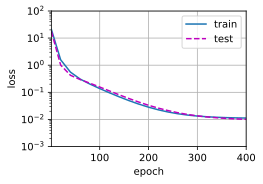

In [25]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### 4.4.4.4 线性函数拟合(欠拟合)
让我们再看看线性函数拟合，减少该模型的训练损失相对困难。 在最后一个迭代周期完成后，训练损失仍然很高。 当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[3.4408126 3.4851131]]


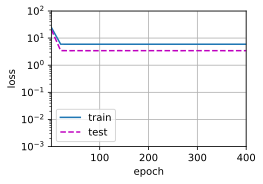

In [26]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

#### 4.4.4.5 高阶多项式函数拟合(过拟合)
现在，让我们尝试使用一个阶数过高的多项式来训练模型。 在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。 因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。 虽然训练损失可以有效地降低，但测试损失仍然很高。 结果表明，复杂模型对数据造成了过拟合。

weight: [[ 4.976801    1.2665902  -3.309435    5.2080503  -0.23665097  1.1486408
   0.23488462  0.03789273 -0.16087632 -0.16318965  0.18192999  0.1488112
  -0.19703092  0.04636229 -0.1338907  -0.03699858 -0.19467986  0.19393516
  -0.19200751  0.1032567 ]]


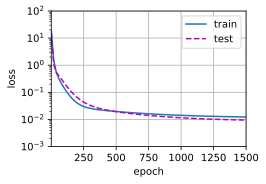

In [27]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)